Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR - False Positive Rate (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm

from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('hw_aa.csv', sep = ';', index_col=[0])

In [3]:
df

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...
127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


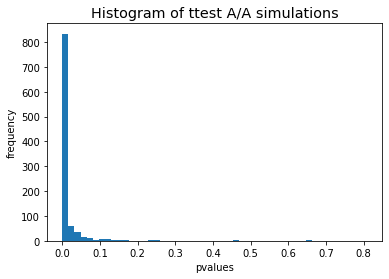

0.931

In [4]:
# Проводим А/А тест
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Судя по результатам А/А теста наши группы не равны. Видимо проблема в системе сплитования. Необходимо проверить наши исходные данные

In [5]:
df.groupby(['experimentVariant', 'version'], as_index = False) \
  .agg({'purchase': 'mean'})

,experimentVariant,version,purchase
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


Если посмотреть на данные, то можно заметить, что в версии моб. приложения v2.8.0 конверсия в двух группах сильно отличается. Проверим предположение разными статистическими методами.

In [6]:
# Проверим на наличие статистически значимых различий с помощью t-testa
stats.ttest_ind((df[(df.experimentVariant == 0) & (df.version == 'v2.8.0')]['purchase']), (df[(df.experimentVariant == 1) & (df.version == 'v2.8.0')]['purchase']))

Ttest_indResult(statistic=-42.963540840360324, pvalue=0.0)

p-value < 0.05, согласно данному тесту группы не равны. Для уверенности проверим с помощью непараметрического аналога - теста Манна-Уитни.

In [7]:
stats.mannwhitneyu((df[(df.experimentVariant == 0) & (df.version == 'v2.8.0')]['purchase']), (df[(df.experimentVariant == 1) & (df.version == 'v2.8.0')]['purchase'])) # Проводим тест

MannwhitneyuResult(statistic=819431781.5, pvalue=0.0)

Тест также показал, что группы статистически значимо различаются. Теперь проверим с помощью А/А теста на вероятность ложноположительного результата между группами. 

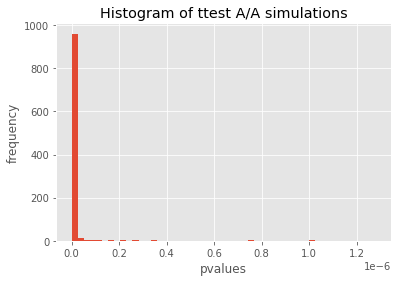

1.0

In [8]:
# Проводим А/А тест
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 0) & (df.version == 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 1) & (df.version == 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Проверка показала, что данные группы совершенно не равны и количество ложноположительных случаев = 100%
Исключим данную версию из данных и еще раз запустим тест.

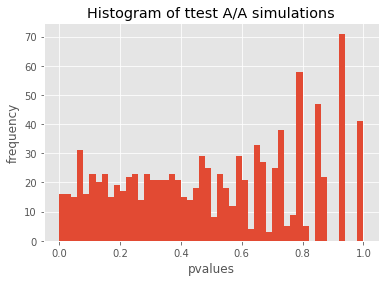

0.041

In [9]:
# Проводим А/А тест
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 0) & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 1) & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Исключив версию мобильньного приложения v2.8.0, мы получили результат, в котором количество ложноположительных результатов не привышает альфа = 0.05, задача решена.